In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [2]:
## define some numbers
Number_para = 20
obs_N = 15
number_burnin = 1000
number_sample = 2000
steps_gradient_decent = 50

In [3]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

In [4]:
pi = constant64(m.pi) # define PI in Tensorflow form

In [5]:
depth = constant64(-20)
thickness = constant64(20)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [6]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(x,z,loc):

    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = constant64(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(x,z):

    thick = thickness

    x_obv = tf.linspace(constant64(-70.),constant64(70.),obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float64, size=obv.shape[0]-2)

    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return tf.reshape(gravity.stack(),shape = [obs_N])



def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

Define the Prior and likelihood distribution

In [7]:
# prior
mu_prior = -20.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 10.*tf.eye(Number_para,dtype = tf.float64)

# likelihood
sig_e = constant64(0.0000001)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [8]:
tf.random.set_seed(7)
control_position = tf.random.normal([Number_para],-20,7,dtype = tf.float64)
control_index = tf.linspace(constant64(-70),constant64(70),Number_para)

fix_point1 = tf.reshape(constant64([[-150.,-20],[-100,-20]]),shape = [2,2])
fix_point2 = tf.reshape(constant64([[100,-20],[150,-20]]),shape = [2,2])


def GaussianProcess_model(control_index,control_position,visual = False,resolution = None):
    if resolution is None:
        resolution=3
    points = tf.stack([control_index,control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+4,1])
    amplitude = tfp.util.TransformedVariable(
      2, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      1000, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-10), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry
    if visual == True:
        visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],100),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    
    if visual == True:
        gprm_visual = tfd.GaussianProcessRegressionModel(
            kernel=kernel,
            index_points=visual_index,
            observation_index_points=observation_index_points,
            observations=points[:,1],
            observation_noise_variance=observation_noise_variance)
        visual_position = gprm_visual.sample(1,seed =1)
        plt.scatter(control_index,control_position,c = 'r')
        plt.plot(tf.transpose(visual_index).numpy()[0],visual_position[0])
        
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[1]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete



In [9]:
def GaussianProcess_model_plot(control_index,control_position,ax = None,resolution = None,**args):
    if resolution is None:
        resolution=3
    if ax is None:
        f,ax = plt.subplots()
        
    points = tf.stack([control_index,control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

    observation_index_points = tf.reshape(points[:,0],[Number_para+4,1])
    amplitude = tfp.util.TransformedVariable(
      2, tfb.Exp(), dtype=tf.float64, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
      1000, tfb.Exp(), dtype=tf.float64, name='length_scale')
    kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-10), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

    # We'll use an unconditioned GP to train the kernel parameters.
    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points,
        observation_noise_variance=observation_noise_variance)
    
    optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
    @tf.function
    def optimize():
        with tf.GradientTape() as tape:
            loss = -gp.log_prob(points[:,1])
        grads = tape.gradient(loss, gp.trainable_variables)
        optimizer.apply_gradients(zip(grads, gp.trainable_variables))
        return loss
    # First train the model, then draw and plot posterior samples.
    for i in range(1000):
        neg_log_likelihood_ = optimize()

    ### discretize the geometry

    visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],100),axis =1)
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    
    tf.random.set_seed(1)
    model_position = gprm.sample(1,seed = 1)
    

    gprm_visual = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=visual_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)
    visual_position = gprm_visual.sample(1,seed =1)
    ax.scatter(control_index,control_position,c = 'r',**args)
    ax.plot(tf.transpose(visual_index).numpy()[0],visual_position[0],'b',**args)
    
    return 

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


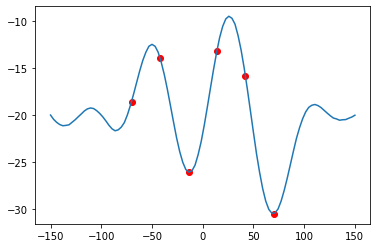

In [10]:
x,z = GaussianProcess_model(control_index,control_position,visual = True)

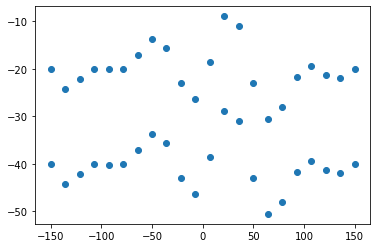

In [11]:
plt.scatter(x,z)

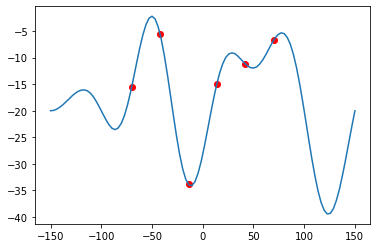

In [13]:
## generate some true observation gravity data

True_position = tf.random.normal([Number_para],-20,10,dtype = tf.float64)

x_true,z_true = GaussianProcess_model(control_index,True_position,visual =True)
D = grav(x_true,z_true)

#### create some noise

In [16]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =constant64(0),stddev =sig_e,seed = 1,dtype = tf.float64)

In [17]:
D_noise = D+noise

In [18]:
def grav_calculate(x,z,x_obs=None, R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,201)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(x,z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
    ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

### Full Gravity response at surface

array([[7.44380780e-06],
       [7.49211772e-06],
       [7.54172033e-06],
       [7.59257880e-06],
       [7.64465018e-06],
       [7.69788513e-06],
       [7.75222763e-06],
       [7.80761461e-06],
       [7.86397532e-06],
       [7.92123051e-06],
       [7.97929126e-06],
       [8.03805727e-06],
       [8.09741460e-06],
       [8.15723262e-06],
       [8.21735998e-06],
       [8.27761943e-06],
       [8.33780110e-06],
       [8.39765397e-06],
       [8.45687490e-06],
       [8.51509478e-06],
       [8.57186105e-06],
       [8.62661618e-06],
       [8.67867221e-06],
       [8.72718340e-06],
       [8.77112254e-06],
       [8.80927441e-06],
       [8.84027010e-06],
       [8.86269496e-06],
       [8.87529033e-06],
       [8.87721585e-06],
       [8.86826070e-06],
       [8.84887949e-06],
       [8.82003276e-06],
       [8.78293640e-06],
       [8.73884232e-06],
       [8.68890457e-06],
       [8.63412320e-06],
       [8.57533664e-06],
       [8.51323748e-06],
       [8.44839638e-06],


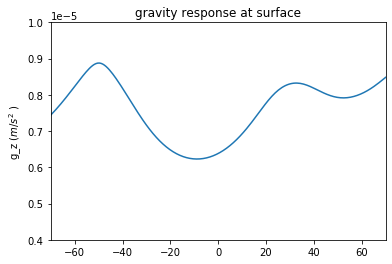

In [19]:
grav_calculate(x_true,z_true)

## Plotting function

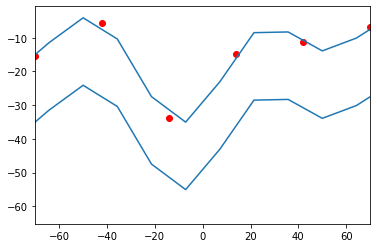

In [20]:
def Draw_inter(_control_index,_control_position,x_true = None,z_true = None,R = 70, ax = None):
    if ax is None:
        _,ax = plt.subplots()
    if z_true is None:
        x_true,z_true = GaussianProcess_model(_control_index,_control_position)
    ax.scatter(control_index,True_position, c = 'red')
    ax.plot(x_true,z_true)
    ax.set_xlim(-R,R)
Draw_inter(control_index,True_position)

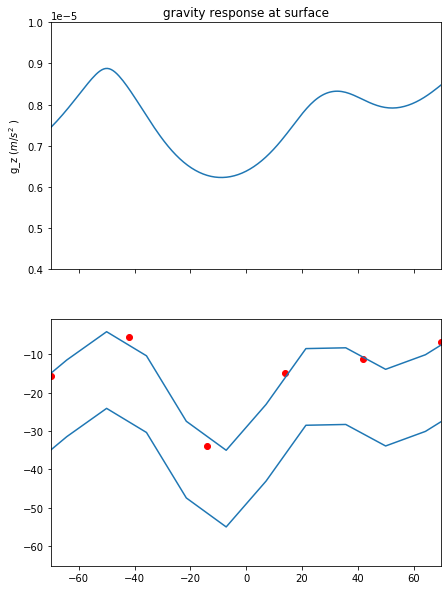

In [21]:
def Draw(_control_index,_control_position):
    f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(_control_index,_control_position)
    grav_calculate(_x,_z,ax = ax[0])
    Draw_inter(_control_index,_control_position,ax = ax[1])
Draw(control_index,True_position)

In [22]:
x_obs = np.linspace(-70,70,obs_N+2)

### Gravity response at receivers

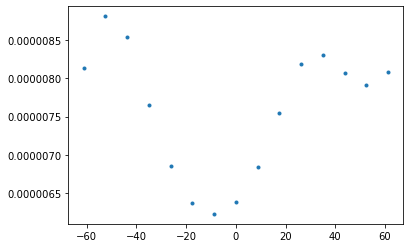

In [23]:
plt.plot(x_obs[1:-1],D,'.')

#### Gradient decent

In [24]:
mu = tf.random.uniform([Number_para],minval = -20,maxval = -2,seed = 1,dtype = tf.float64) # initial parameters

(4e-06, 1e-05)

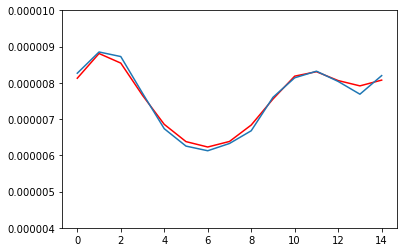

In [25]:
f,ax = plt.subplots()
ax.plot(D,'r')
ax.plot(D_noise)
ax.set_ylim(4e-6,10e-6)

In [26]:
steps_gradient_decent = 50

loss tf.Tensor(209.03568769938238, shape=(), dtype=float64)
grad tf.Tensor(
[-11.31114509 -11.42805914  44.68768709  18.48419258 -24.01998916
 -10.24647852], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-10.87052517  -8.66058677 -20.41124413 -13.53502438 -12.36284986
 -14.31784964], shape=(6,), dtype=float64)
Iteration 0
loss tf.Tensor(-34.922376173631335, shape=(), dtype=float64)
grad tf.Tensor(
[ -5.43113684  -5.81940843  23.64032637   8.37052696 -14.91516589
  -7.09582629], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-10.32741148  -8.07864593 -22.77527676 -14.37207708 -10.87133327
 -13.60826701], shape=(6,), dtype=float64)
Iteration 1
loss tf.Tensor(-110.73683280354635, shape=(), dtype=float64)
grad tf.Tensor([-1.84305623 -3.14439108 14.92839596  5.04983911 -8.68680043 -5.02619755], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-10.14310586  -7.76420682 -24.26811636 -14.87706099 -10.00265323
 -13.10564725], shape=(6,), dtype=float64)
Iteration 2
loss tf.Tensor(-139.44590968979185, shape=(

loss tf.Tensor(-183.26962346348176, shape=(), dtype=float64)
grad tf.Tensor([ 0.71108377 -0.24467576  0.87764927 -0.04206417  0.24424086 -0.42343861], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-14.04928002  -6.60562839 -31.48382307 -16.16785423 -10.65917841
 -10.7761721 ], shape=(6,), dtype=float64)
Iteration 27
loss tf.Tensor(-183.4035307007773, shape=(), dtype=float64)
grad tf.Tensor([ 0.65723065 -0.22921394  0.82051628 -0.043654    0.22870927 -0.41169356], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-14.11500308  -6.58270699 -31.56587469 -16.16348883 -10.68204933
 -10.73500275], shape=(6,), dtype=float64)
Iteration 28
loss tf.Tensor(-183.52271051825323, shape=(), dtype=float64)
grad tf.Tensor([ 0.61233093 -0.21332637  0.7641715  -0.04949782  0.21252746 -0.39645411], shape=(6,), dtype=float64)
mu: tf.Tensor(
[-14.17623618  -6.56137436 -31.64229184 -16.15853905 -10.70330208
 -10.69535734], shape=(6,), dtype=float64)
Iteration 29
loss tf.Tensor(-183.62669242902473, shape=(), dtype=floa

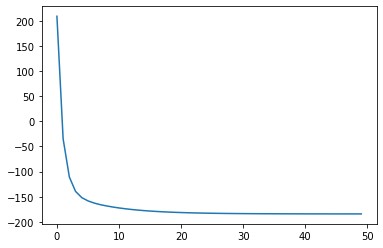

In [29]:
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(D,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('loss',loss)
        print('grad',dlossdmu)
    mu = mu-tf.multiply(constant64(0.1),dlossdmu)
    print('mu:',mu)
    print('Iteration',i)
plt.plot(lost)

In [30]:
MAP = mu

In [31]:
negative_log_posterior(D,True_position)

<tf.Tensor: shape=(), dtype=float64, numpy=-180.58276901926132>

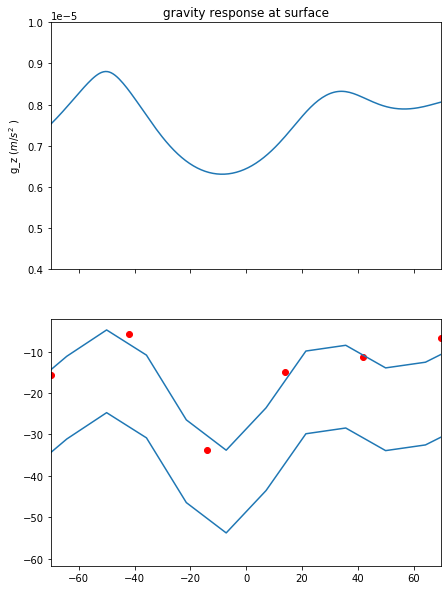

In [32]:
Draw(control_index,MAP)

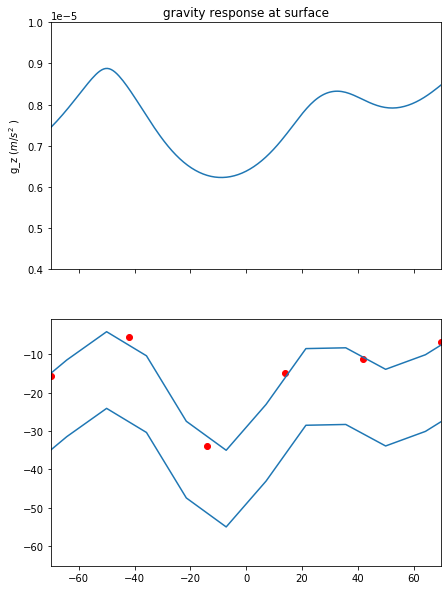

In [33]:
Draw(control_index,True_position)

### Random Walk MCMC

In [35]:
num_results = number_sample
burnin = number_burnin

initial_chain_state = [
    -15 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [36]:
samples

array([[[-14.95540993],
        [-14.85600329],
        [-15.13864436],
        [-14.94881747],
        [-14.91203611],
        [-14.86709583]],

       [[-14.50980008],
        [-14.90736808],
        [-15.12192541],
        [-15.18054145],
        [-14.91665124],
        [-15.05168629]],

       [[-14.06419024],
        [-14.95873287],
        [-15.10520646],
        [-15.41226544],
        [-14.92126637],
        [-15.23627676]],

       [[-13.61858039],
        [-15.01009767],
        [-15.08848751],
        [-15.64398942],
        [-14.92588149],
        [-15.42086722]],

       [[-13.17297054],
        [-15.06146246],
        [-15.07176856],
        [-15.8757134 ],
        [-14.93049662],
        [-15.60545768]],

       [[-12.7273607 ],
        [-15.11282726],
        [-15.05504961],
        [-16.10743739],
        [-14.93511175],
        [-15.79004815]],

       [[-12.28175085],
        [-15.16419205],
        [-15.03833066],
        [-16.33916137],
        [-14.93972688],
    

In [37]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [38]:
accepted_samples.shape[0]/num_results

1.0

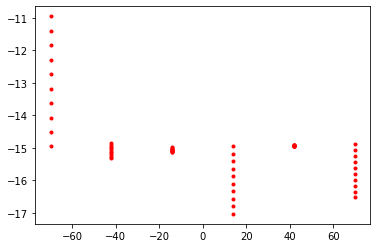

In [39]:
for ps in samples:
    plt.plot(np.linspace(-70,70,Number_para),ps,'r.')

In [40]:
#TODO
def draw_MCMC(samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
    
#     if Truth is not None:
#         draw(base,Truth,ax = ax, R = R)
            
    x_cor = tf.linspace(constant64(-70),constant64(70),Number_para)
    
    for ps in samples:
        ax.plot(x_cor,ps,'r.',alpha =0.2)
        ps = tf.reshape(ps,[ps.shape[0]])
        GaussianProcess_model_plot(control_index,ps,ax = ax, alpha = 0.1)
    ax.set_ylim(-30,0)   
    ax.set_xlim(-R,R)

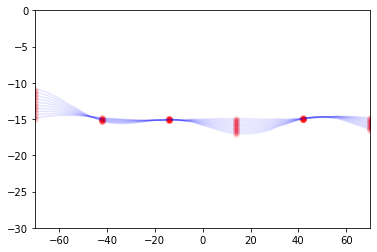

In [41]:
draw_MCMC(samples) # [:,:,0] transpost the results for plotting

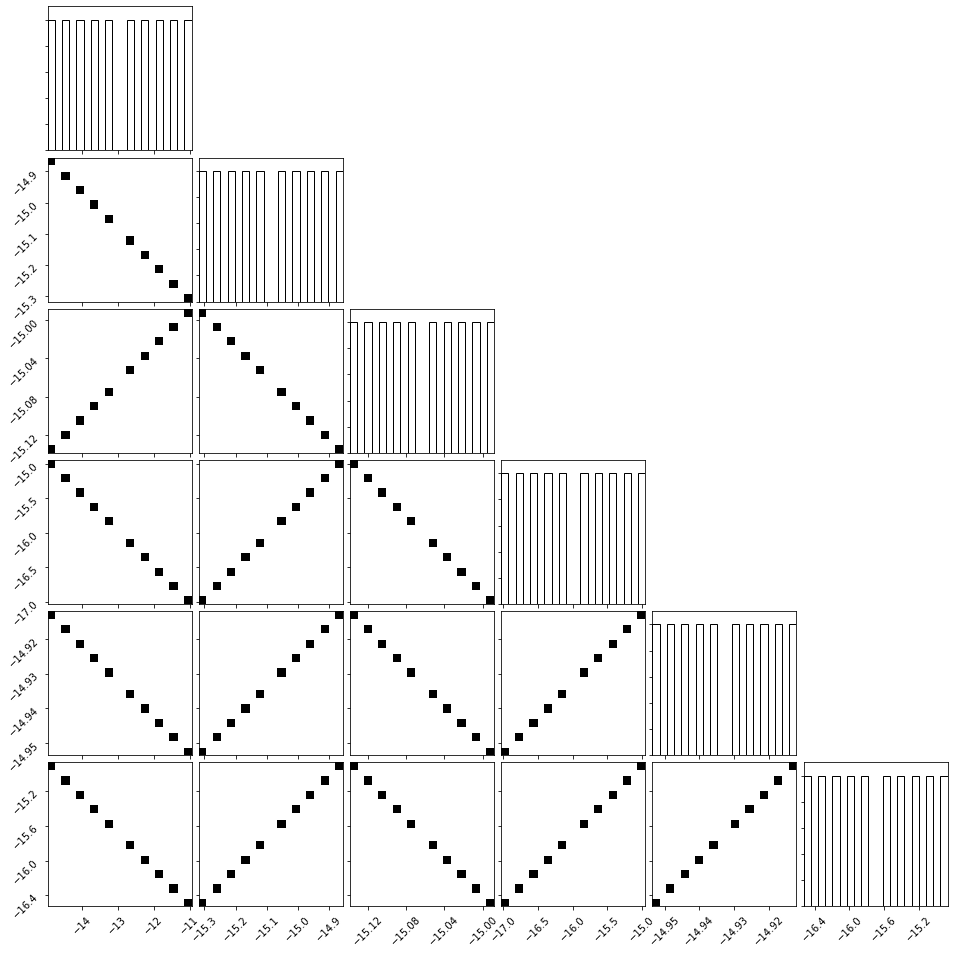

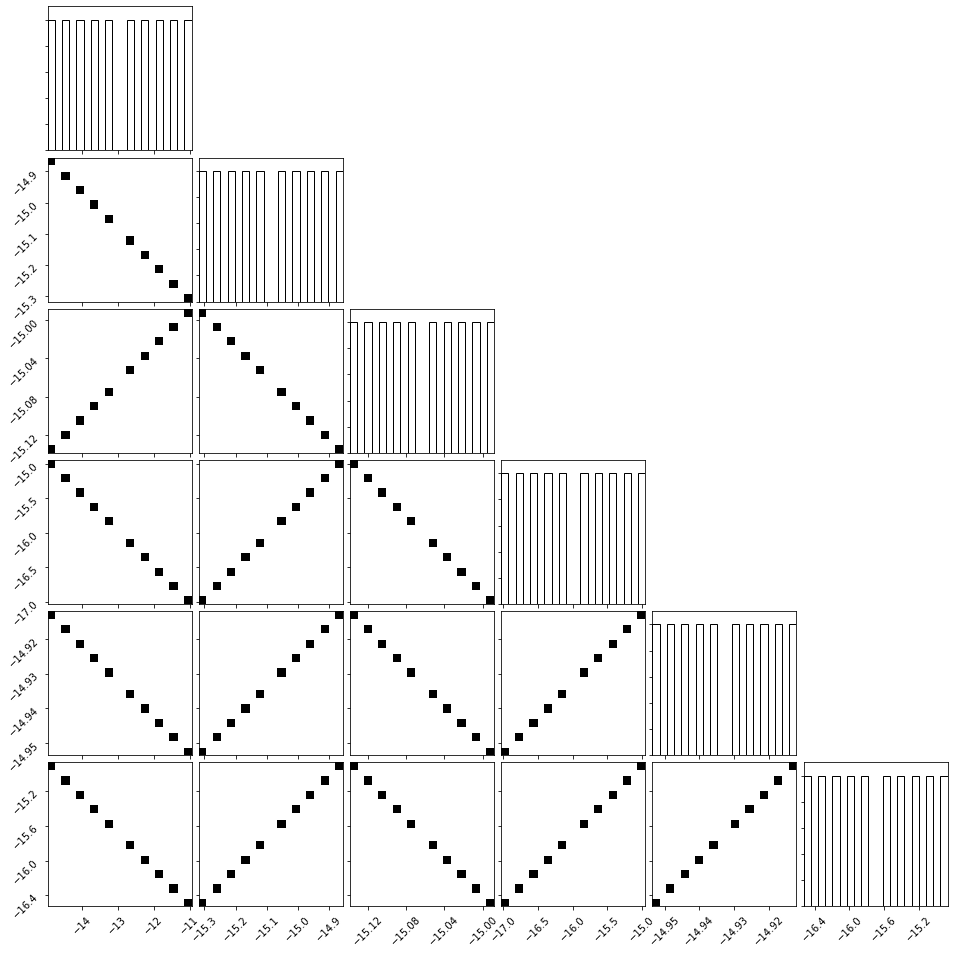

In [42]:
corner.corner(accepted_samples[:,:,0])

# Hessian Method

### Could be parelized?

In [43]:
with tf.GradientTape() as t:
    t.watch(MAP)
    with tf.GradientTape() as tt:
        tt.watch(MAP)
        loss = negative_log_posterior(D,MAP)
    jac = tt.gradient(loss,MAP,unconnected_gradients='zero')
hess = t.gradient(jac,MAP,unconnected_gradients = 'none')

In [44]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        print(j)
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(D,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = Full_Hessian()

0
1
2
3
4
5


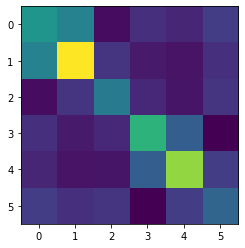

In [45]:
plt.imshow(New_Hessian)

In [46]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [47]:
cov_post = Laplace_appro(New_Hessian,cov_prior)

In [48]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float64)
    matrix2 = tf.cast(matrix2,tf.float64)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(constant64(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.add(negative_log_posterior(D,m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.add(negative_log_posterior(D,m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = constant64(0.9)

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float64)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [49]:
mu_init = -15 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_gpCN = np.array(accepted)



Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Acceptance rate = 30.0%


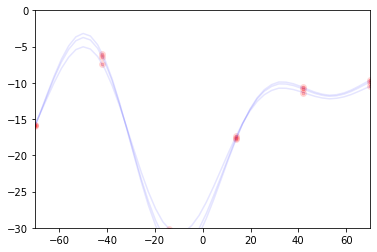

In [50]:
draw_MCMC(accepted_gpCN)

### try pCN MCMC

first define a likelihood function rather than posteior function

In [51]:
def log_likelihood(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_likelihood.log_prob(D))

def negative_likeli(_control_position):
    return tf.negative(log_likelihood(D,_control_position))

In [52]:
negative_likeli(mu)

<tf.Tensor: shape=(), dtype=float64, numpy=-224.8273346875486>

In [53]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(m_current)
    delta_proposed = negative_likeli(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [54]:
mu_init = -15 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_pCN = np.array(accepted)

Acceptance rate = 90.0%


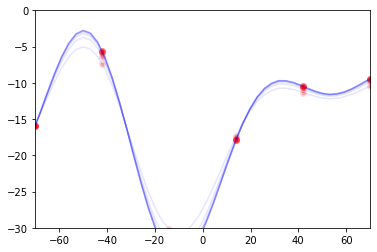

In [55]:
draw_MCMC(accepted_pCN)

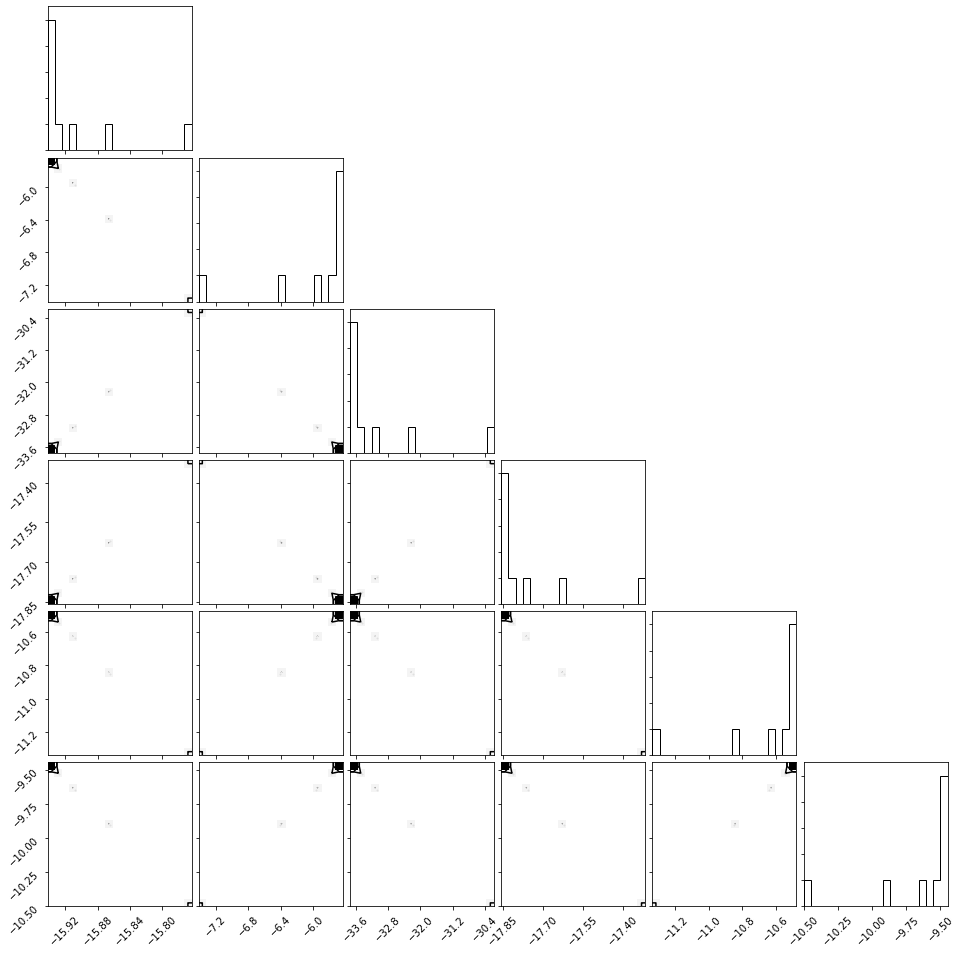

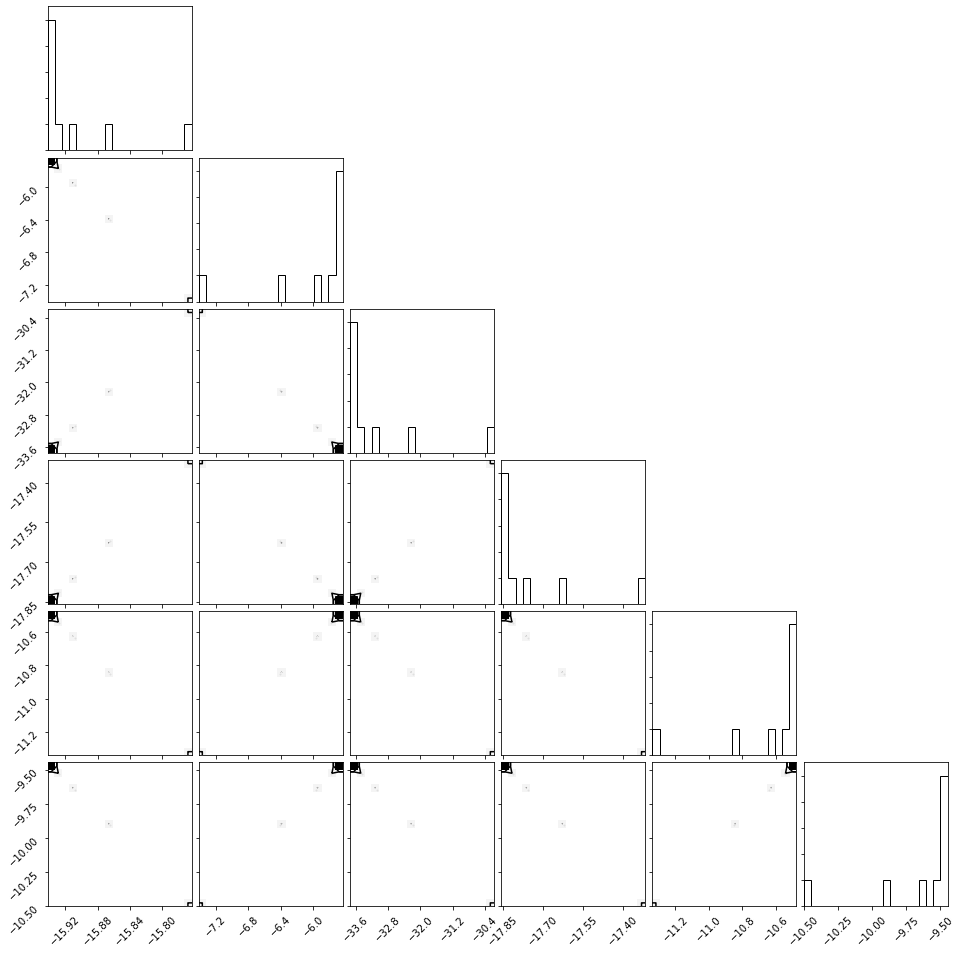

In [56]:
corner.corner(accepted_pCN)

In [57]:
print('run success')

run success
